In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
! pip install ultralytics --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 19.4 MB/s eta 0:00:0000:01


In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="SqxHxUmH1bESmMpTc8Wo")
project = rf.workspace("field-planttutorial").project("field-plant")
version = project.version(2)
dataset = version.download("yolov11")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 68.8 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Field-plant-2 in yolov11:: 100%|██████████| 9862/9862 [00:12<00:00, 808.25it/s] 


In [3]:
# Import necessary libraries
import torch
import os
import cv2
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from roboflow import Roboflow
from ultralytics import YOLO
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [4]:
import os
import pandas as pd
from collections import Counter

labels_path = "/kaggle/working/Field-plant-2/train/labels/"
label_files = os.listdir(labels_path)

class_counts = Counter()

for file in label_files:
    with open(os.path.join(labels_path, file), "r") as f:
        for line in f:
            class_id = line.split()[0]
            class_counts[class_id] += 1

df = pd.DataFrame(class_counts.items(), columns=["Class ID", "Count"])
print(df.sort_values("Count", ascending=True))



   Class ID  Count
25        6      1
24       16      6
23       12      7
21       13      8
22       25     11
4        10     13
13       17     13
20        0     17
9         7     21
18        8     27
17       20     30
15       11     33
2         4     50
19       26     75
14       15    113
12        9    115
16        1    128
3         5    156
7        14    180
10       24    190
8        23    273
11        2    286
6        18    338
5        21   1142
0        19   1164
1         3   1367


In [5]:
if class_id in ['6', '16', '12', '13', '25','10','17','0','7','8','20','11','4','26']:  # Undersampled classes
    transform = A.Compose([
        A.Resize(640, 640),
        A.RandomBrightnessContrast(p=0.5),  # Higher probability
        A.HorizontalFlip(p=0.7),
        A.VerticalFlip(p=0.7),
        A.Rotate(limit=30, p=0.7),  # More aggressive rotation
        A.Blur(blur_limit=3, p=0.3),
        A.Cutout(num_holes=8, max_h_size=8, max_w_size=8, p=0.5)  # Add cutout for more diversity
    ])
else:
    transform = A.Compose([
        A.Resize(640, 640),
        A.RandomBrightnessContrast(p=0.2),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=20, p=0.5),
        A.Blur(blur_limit=3, p=0.2)
    ])


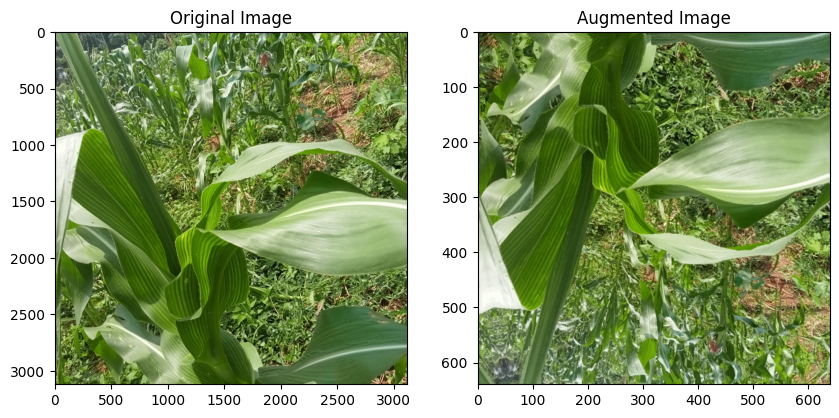

In [6]:
# Path to training images and labels
train_images_path = "/kaggle/working/Field-plant-2/train/images/"
train_labels_path = "/kaggle/working/Field-plant-2/train/labels/"

# Load and preprocess a sample image
sample_image_path = os.path.join(train_images_path, os.listdir(train_images_path)[0])
image = cv2.imread(sample_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
augmented = transform(image=image)["image"]

# Display the original and augmented image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[1].imshow(augmented)
ax[1].set_title("Augmented Image")
plt.show()

In [7]:
import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Feature Mapping using PCA
def feature_mapping(image_path, pca_components=10):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
    img = cv2.resize(img, (64, 64))  # Resize to 64x64
    img_flat = img.reshape(64, 64)  # Keep 2D structure

    scaler = StandardScaler()
    img_scaled = scaler.fit_transform(img_flat)  # Normalize pixel values

    pca = PCA(n_components=min(pca_components, img_scaled.shape[1]))  # Ensure valid component count
    img_pca = pca.fit_transform(img_scaled)  # Apply PCA

    return img_pca

# Test with sample image
feature_map = feature_mapping(sample_image_path, pca_components=10)
print("Feature Mapping Output Shape:", feature_map.shape)


Feature Mapping Output Shape: (64, 10)


In [8]:
!yolo detect train data=/content/Field-plant-2/data.yaml \
    model=yolo11m.pt epochs=40 batch=16 lr0=0.00025 imgsz=640 iou=0.7 \
    hsv_h=0.02 hsv_s=0.8 hsv_v=0.5 mosaic=1.0 mixup=0.3 dropout=0.3 \
    cos_lr=True project=/content/training_results name=run_finetuned \
    patience=5

#!ls /content/drive/MyDrive/
#!cp -r /content/training_results /content/drive/MyDrive/Yolo_Training_Results

100%|███████████████████████████████████████| 38.8M/38.8M [00:00<00:00, 231MB/s]
Ultralytics 8.3.94 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=/content/Field-plant-2/data.yaml, epochs=40, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/training_results, name=run_finetuned, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.3, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, 

In [12]:
!yolo detect val data=/kaggle/working/Field-plant-2/data.yaml \
    model=/kaggle/working/Field-plant-2/training_results/run_finetuned_v32/weights/best.pt \
    batch=16 imgsz=640 iou=0.8


Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/cfg/__init__.py", line 958, in entrypoint
    model = YOLO(model, task=task)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/models/yolo/model.py", line 23, in __init__
    super().__init__(model=model, task=task, verbose=verbose)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/model.py", line 148, in __init__
    self._load(model, task=task)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/model.py", line 290, in _load
    self.model, self.ckpt = attempt_load_one_weight(weights)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py", line 1039, in attempt_load_one_weight
    ckpt, weight = torch_safe_load(weight)  # load ckpt
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py", line 944, in torch_safe_load
    ckpt = torch.load(f

In [17]:
!yolo detect predict source=/kaggle/working/Field-plant-2/test/ \
    model=/kaggle/working/Field-plant-2/training_results/run_finetuned_v32/weights/best.pt \
    imgsz=640 conf=0.5 iou=0.8


Ultralytics 8.3.94 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLO11l summary (fused): 190 layers, 25,300,129 parameters, 0 gradients, 86.7 GFLOPs

Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/cfg/__init__.py", line 987, in entrypoint
    getattr(model, mode)(**overrides)  # default args from model
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/model.py", line 550, in predict
    return self.predictor.predict_cli(source=source) if is_cli else self.predictor(source=source, stream=stream)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/predictor.py", line 234, in predict_cli
    for _ in gen:  # sourcery skip: remove-empty-nested-block, noqa
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py", line 36, in generator_context
    response = gen.send(None)
  File "/usr/local/lib/python

In [11]:
!yolo detect train data=/kaggle/working/Field-plant-2/data.yaml \
    model=yolo11l.pt \
    epochs=40 batch=16 lr0=0.00005 imgsz=640 iou=0.8 \
    optimizer=AdamW weight_decay=0.0005 momentum=0.9 \
    patience=5 \
    hsv_h=0.02 hsv_s=0.8 hsv_v=0.5 mosaic=1.0 mixup=0.3 dropout=0.3 \
    cos_lr=True \
    project=/kaggle/working/Field-plant-2/training_results name=run_finetuned_v3


Ultralytics 8.3.94 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=/kaggle/working/Field-plant-2/data.yaml, epochs=40, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/kaggle/working/Field-plant-2/training_results, name=run_finetuned_v3, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.3, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.8, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=Fals

In [14]:
import os

file_path = "/kaggle/working/Field-plant-2/training_results/run_finetuned_v32/labels.jpg"

if os.path.exists(file_path):
    print("File exists:", file_path)
else:
    print("File not found!")


File not found!


In [13]:
from IPython.display import Image, display  # Import display to show images

print("GROUND TRUTH TRAINING DATA:")
display(Image(filename='/kaggle/working/Field-plant-2/training_results/run_finetuned_v32/labels.jpg', width=900))


GROUND TRUTH TRAINING DATA:


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/Field-plant-2/training_results/run_finetuned_v32/labels.jpg'

In [15]:
!yolo detect val \
    data=/kaggle/working/Field-plant-2/data.yaml \
    model=/kaggle/working/Field-plant-2/training_results/run_finetuned_v3/weights/best.pt \
    batch=16 imgsz=640 iou=0.8 \
    project=/kaggle/working/Field-plant-2/training_results \
    name=val_results


Ultralytics 8.3.94 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLO11l summary (fused): 190 layers, 25,300,129 parameters, 0 gradients, 86.7 GFLOPs
val: Scanning /kaggle/working/Field-plant-2/valid/labels.cache... 734 images, 0 
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        734       1226      0.741      0.672      0.749      0.623
Cassava Bacterial Blight          3          4          0          0      0.146     0.0598
Cassava Brown Leaf Spot         27         28      0.527        0.5      0.501      0.433
       Cassava Healthy         47         63      0.727       0.81      0.834       0.71
        Cassava Mosaic        150        272      0.783      0.794      0.866      0.679
      Cassava Root Rot         17         18      0.551        0.5      0.584      0.498
      Corn Brown Spots         30         37      0.706      0.514      0.669      0.472
Corn Chlorotic Leaf Spot          3          

In [16]:
!yolo detect val \
    data=/kaggle/working/Field-plant-2/data.yaml \
    model=/kaggle/working/Field-plant-2/training_results/run_finetuned_v3/weights/best.pt \
    batch=16 imgsz=640 iou=0.8 \
    project=/kaggle/working/Field-plant-2/training_results \
    name=test_results \
    split=test


Ultralytics 8.3.94 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLO11l summary (fused): 190 layers, 25,300,129 parameters, 0 gradients, 86.7 GFLOPs
val: Scanning /kaggle/working/Field-plant-2/test/labels... 737 images, 0 backgro
val: New cache created: /kaggle/working/Field-plant-2/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        737       1207      0.713      0.585      0.695      0.563
Cassava Bacterial Blight          2          4          0          0     0.0505      0.047
Cassava Brown Leaf Spot         30         37      0.779      0.665      0.677      0.556
       Cassava Healthy         40         68      0.815      0.691      0.781      0.647
        Cassava Mosaic        159        251      0.751       0.88      0.905      0.736
      Cassava Root Rot          8          9      0.774      0.764      0.671      0.612
      Corn Brown Spots         22         27       0.85      0